<h1 style="text-align:center;">
Survie des facteurs financiers : analyse de la durée de vie des primes factorielles sur les marchés financiers
</h1>


## Plan

- **I.** Introduction  
- **II.** Analyse exploratoire  
- **III.** Formalisation du problème de survie  
- **IV.** Modèles paramétriques (EMV)  
- **V.** Estimation non paramétrique  
- **VI.** Comparaison des estimateurs  
- **VII.** Modèle de Cox avec covariables  
- **VIII.** Extension Deep Learning  
- **IX.** Conclusion


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn
from scipy.stats import skew, kurtosis
from lifelines.statistics import logrank_test, multivariate_logrank_test
import warnings
warnings.filterwarnings("ignore")

# <span style="color:#A0522D">I. Introduction  :</span> 

## I.1 Problématique

Dans les marchés financiers modernes, des centaines de facteurs quantitatifs sont utilisés pour expliquer les rendements des actifs et pour construire des stratégies d’investissement. Ces facteurs — tels que value, momentum ou quality — génèrent des primes de risque systématiques exploitées par les investisseurs institutionnels et les fonds quantitatifs. Cependant, ces primes ne sont pas permanentes : avec le temps, la performance d’un facteur tend à s’éroder, sa significativité statistique diminue et son avantage compétitif disparaît progressivement. Ce phénomène est souvent désigné comme la décroissance ou la défaillance d’un facteur.

L’apparition de nouveaux facteurs, la saturation des marchés, l’évolution des régimes économiques ou encore la concurrence algorithmique peuvent influencer la durée de validité de ces signaux. Pour les gestionnaires de portefeuille, cette incertitude représente un défi majeur : continuer à exploiter un facteur obsolète peut entraîner des pertes importantes, tandis qu’abandonner trop tôt un facteur robuste peut réduire la performance globale. Il devient donc crucial de quantifier la durée de vie des facteurs et d’identifier les conditions dans lesquelles ils cessent d’être efficaces.

Afin d’analyser cette problématique, nous proposons d’appliquer des méthodes d’analyse de survie. Cette approche statistique, habituellement utilisée dans les domaines biomédical ou industriel, permet de modéliser le temps jusqu’à la survenue d’un événement — ici, l’“échec” d’un facteur financier. L’analyse de survie permet également de prendre en compte la censure, c’est-à-dire les facteurs toujours actifs au moment de l’analyse, ce que les méthodes classiques de performance ne gèrent pas correctement.

Ce travail vise donc à :

- modéliser la durée de vie de différents facteurs quantitatifs ;

- comparer leur probabilité de défaillance ;

- étudier l’influence de covariables (notamment le style économique du facteur, et des statistiques résumées de la série) sur le risque de défaillance.

Les résultats obtenus doivent aider les investisseurs institutionnels à optimiser la rotation factorielle, à réduire les coûts d’exposition et à améliorer la résilience de leurs portefeuilles face à la dégradation progressive des signaux quantitatifs.

## I.2 description des données

- Le jeu de données utilisé dans ce projet provient de la base Open Source Asset Pricing (OSAP), développée par Bryzgalova, Linnainmaa et Lustig (Université de Chicago, Stanford et UCLA).
Cette base de données open-source a pour objectif de reproduire et de centraliser les principaux facteurs de rendement présentés dans la littérature académique en finance empirique entre 1962 et 2024.


- Plus précisément, nous utilisons le fichier « Monthly Long-Short Returns of 212 Predictors », qui regroupe les rendements mensuels des portefeuilles long-short associés à plus de 200 facteurs (ou « prédicteurs »). Chaque colonne représente un facteur différent, construit selon les définitions des articles de recherche originaux (par exemple Value, Momentum, Investment, Profitability, Liquidity, etc.), tandis que chaque ligne correspond à un mois calendaire.


- Les rendements sont exprimés sous forme de taux mensuels ajustés du risque, calculés sur des portefeuilles neutres au marché. Ces données sont largement utilisées dans les études de validation empirique de modèles d’évaluation d’actifs et de stratégies factorielles (factor investing).

- Pour assurer la qualité statistique de l’échantillon, nous avons restreint notre période d’analyse à 1970–2024, période durant laquelle la majorité des facteurs disposent d’un historique complet. Les données sont déjà harmonisées et nettoyées par les auteurs de la base, ce qui garantit leur fiabilité et permet de se concentrer sur l’analyse méthodologique plutôt que sur la reconstruction des variables.

- parmi les plus de 200 facteurs disponibles dans la base Open Source Asset Pricing, nous avons choisi d’en retenir 15, représentant les dimensions les plus fondamentales de la littérature en finance empirique.
Cette sélection vise à réduire la complexité du jeu de données tout en conservant la diversité économique des sources de rendement.

Chaque valeur correspond au rendement mensuel (en %) du portefeuille long–short associé au facteur : une valeur positive indique un mois favorable pour la stratégie factorielle, une valeur négative une sous-performance.

## I.3 Prétraitement des données

Nous appliquons les étapes suivantes avant de construire les variables de survie :

1) **Nettoyage des colonnes** : suppression des espaces, harmonisation du nom de la colonne date.  
2) **Gestion des dates** : conversion en `datetime`, tri chronologique, indexation mensuelle.  
3) **Filtrage temporel** : restriction à la période 1970–2024 pour disposer d’un historique homogène.  
4) **Sélection de 15 facteurs** représentatifs (Value, Momentum, Quality, Risk/Volatility, etc.).  
5) **Contrôle qualité** : vérification des valeurs manquantes, cohérence de la fréquence mensuelle.

Le résultat est un fichier nettoyé `clean_factor_returns.csv` utilisé dans la suite.



- La taille de ce jeu de données est : 660 lignes et 15 colonnes
- Période : 1970-01-30 → 2024-12-31
- Nombre de facteurs avec des valeurs manquantes:  0


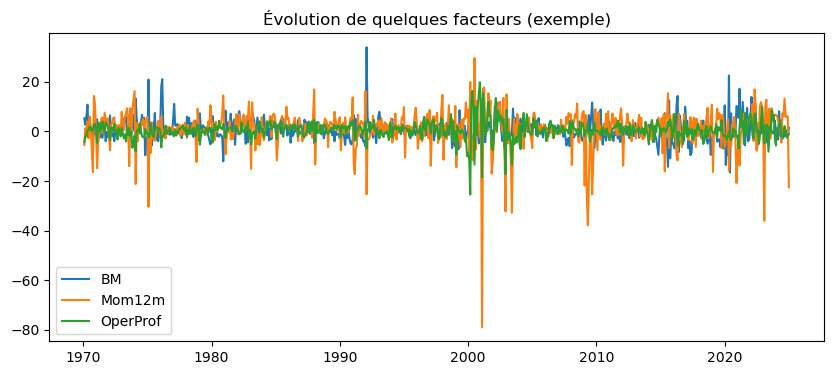

Différence médiane entre deux dates (jours): 31.0
Output clean_factor_returns.csv


In [21]:
# ======================================
# STEP : Lire les données brutes
# ======================================

df = pd.read_csv("PredictorLSretWide.csv")

# ======================================
# STEP : Date
# ======================================

df.columns = df.columns.str.strip()
if 'Date' in df.columns:
    df.rename(columns={'Date': 'date'}, inplace=True)


df['date'] = pd.to_datetime(df['date'], errors='coerce')



df = df.set_index('date').sort_index()

# ======================================
# STEP : 1970-2024
# ======================================
df = df.loc[(df.index >= "1970-01-01") & (df.index <= "2024-12-31")]


# ======================================
# STEP : choix de facteurs
# ======================================
factors = [
    'BM', 'Mom12m', 'OperProf', 'Investment', 'Size', 
    'VolMkt', 'Beta', 'Illiquidity', 'cfp', 'RoE', 
    'Leverage', 'STreversal', 'MaxRet', 'RealizedVol', 'NetPayoutYield'
]

df = df[factors].dropna(how='all')

n_rows, n_cols = df.shape
print(f"- La taille de ce jeu de données est : {n_rows} lignes et {n_cols} colonnes")
print(f"- Période : {df.index.min().date()} → {df.index.max().date()}")

#print(" Nettoyage complet：", df.shape)
#df.head()

# ======================================
# STEP : manque?
# ======================================
missing_ratio = df.isna().mean()
missing_summary = missing_ratio[missing_ratio > 0]
print("- Nombre de facteurs avec des valeurs manquantes: ", len(missing_summary))


# ======================================
# STEP : visu un exemple
# ======================================
'''
print("- Visualisation d'un facteur (Mom12m) ：")
sample_factor = df.columns[1]
df[sample_factor].plot(figsize=(10,4), title=f"Evolution du facteur {sample_factor}")
plt.show()
'''

plt.figure(figsize=(10,4))
for col in df.columns[:3]:
    plt.plot(df.index, df[col], label=col)
plt.title("Évolution de quelques facteurs (exemple)")
plt.legend()
plt.show()




#=============================================
# Vérification (approximative) de la fréquence mensuelle
diff_months = df.index.to_series().diff().dropna().dt.days
print("Différence médiane entre deux dates (jours):", diff_months.median())
#=============================================



# ======================================
# STEP : save
# ======================================
df.to_csv("clean_factor_returns.csv", index=True)
print("Output clean_factor_returns.csv")




## I.3 Choix de la période 1970–2024

La période d’analyse retenue s’étend de janvier 1970 à fin 2024, ce qui correspond à l’intégralité de l’horizon disponible dans notre extraction retenue. Ce choix se justifie pour plusieurs raisons.

Tout d’abord, cette fenêtre temporelle offre une profondeur historique suffisante pour observer la dynamique de performance et d’extinction des facteurs sur plusieurs cycles économiques. Elle couvre des régimes de marché contrastés : inflation des années 1970, dérégulation financière des années 1980, bulle technologique des années 2000, crise financière de 2008, environnement de taux zéro des années 2010, et enfin la période post-pandémique marquée par un retour de l’inflation. Cette diversité conjoncturelle est essentielle pour évaluer la robustesse et la durée de vie des facteurs dans des environnements changeants.

Ensuite, un horizon long permet de réduire le bruit statistique, d’observer plusieurs phases d’apparition et de défaillance, et d’obtenir des séries suffisamment longues pour appliquer des techniques d’analyse de survie de manière fiable, notamment en présence de censures à droite. Une période plus courte réduirait significativement la puissance statistique et augmenterait le risque de conclusions dépendantes d’un régime particulier.

Ainsi, la période 1970–2024 maximise à la fois la qualité statistique, la diversité macroéconomique, la cohérence comptable et la pertinence académique, constituant un horizon approprié pour une étude de survie des facteurs quantitatifs.

## I.4 Présentation des facteurs sélectionnés

### I.4.a) Sélection

- BM — Book-to-Market : mesure le ratio entre la valeur comptable et la valeur de marché, indicateur classique du style value.

- Mom12m — 12-Month Momentum : capture la persistance des performances passées sur les douze derniers mois.

- OperProf — Operating Profitability : mesure la rentabilité opérationnelle d’une entreprise, liée à la qualité de gestion.

- Investment — Investment Growth : reflète le taux de croissance des actifs ; une expansion trop rapide est souvent associée à des rendements futurs faibles.

- Size — Market Capitalization : proxy de la taille de l’entreprise ; les petites capitalisations tendent historiquement à surperformer.

- VolMkt — Market Volatility Exposure : mesure la sensibilité du facteur aux variations globales de volatilité du marché.

- Beta — Market Beta : coefficient de sensibilité du rendement au marché, issu du CAPM.

- Illiquidity — Illiquidity Premium : prime rémunérant la détention de titres difficiles à échanger ; illustrée par l’amplitude du spread.

- cfp — Cash-Flow-to-Price : compare les flux de trésorerie au prix de l’action ; indicateur de valorisation fondamental.

- RoE — Return on Equity : rapporte le résultat net aux fonds propres ; indicateur traditionnel de rentabilité financière.

- Leverage — Financial Leverage : reflète le niveau d’endettement de l’entreprise ; un levier élevé augmente le risque de défaillance financière.

- STreversal — Short-Term Reversal : capture les corrections de prix à horizon très court liées aux micro-bruits de marché.

- MaxRet — Maximum Daily Return : mesure la présence de retours extrêmes ; souvent associé à des comportements spéculatifs.

- RealizedVol — Realized Volatility : volatilité empirique observée sur une fenêtre donnée, représentative du risque local.

- NetPayoutYield — Net Payout Yield : combine dividendes, rachats et émissions d’actions ; indicateur de politique de distribution.

### I.4.b) Motivation de la sélection

Ces facteurs ont été retenus selon les critères suivants :

- Représentativité académique : facteurs classiques, validés empiriquement.

- Diversité des mécanismes économiques : évite la concentration d’expositions.

- Disponibilité et qualité des séries temporelles : fréquence mensuelle longue.

- Pertinence industrielle : utilisés dans les modèles multifactoriels modernes.

- Comparabilité inter-facteurs : permet d’évaluer leurs “durées de vie” dans des régimes de marché différents.


### I.4.c) Tableau récapitulatif

| Facteur | Catégorie |
|---|---|
| BM, cfp | Value |
| Mom12m, STreversal, MaxRet | Momentum / Reversal |
| OperProf, RoE | Quality / Profitability |
| Investment, NetPayoutYield | Investment / Payout |
| Size, Beta, Leverage | Risk |
| Illiquidity | Liquidity |
| VolMkt, RealizedVol | Volatility |


## I.5 Préparation des données pour l’analyse de survie

L’objectif est de transformer les séries de rendements mensuels en un jeu de données “survie” au niveau **facteur**.

Dans ce contexte :

- $T$ désigne le **nombre de mois** écoulés avant la première **défaillance** d’un facteur selon une règle opérationnelle (définie en Section III).  
- $\delta$ est un indicateur d’événement : $(\delta=1)$ si la défaillance est observée avant la fin de l’horizon, $(\delta=0)$ si l’observation est **censurée** (facteur encore “actif” fin 2024).  
- $S(t)$ représente la probabilité qu’un facteur reste actif au-delà de $t$ mois.

Le tableau de survie final contiendra au minimum :

| Variable | Description |
|---|---|
| factor | nom du facteur |
| T | durée (en mois) jusqu’à la défaillance ($(T>0)$) |
| event | indicateur d’événement ($(1)$ =défaillance, $(0)$ =censuré) |
| style | catégorie économique (Value, Momentum, Quality, Risk, Investment, etc.) |


# <span style="color:#A0522D">II. Analyse exploratoire :</span>


## II.1 Objectifs de l'analyse exploratoire

Avant de définir un temps de survie et d’estimer des courbes $(S(t))$, nous analysons :

- la qualité des données (valeurs manquantes, période couverte) ;

- la distribution et la volatilité des rendements factoriels ;

- la dépendance entre facteurs (corrélations), afin d’interpréter ensuite les résultats de survie.

Shape: (660, 15)
Période: 1970-01-30 → 2024-12-31

Valeurs manquantes :


BM             0.0
Mom12m         0.0
OperProf       0.0
Investment     0.0
Size           0.0
VolMkt         0.0
Beta           0.0
Illiquidity    0.0
cfp            0.0
RoE            0.0
dtype: float64

,mean,std,min,max
Mom12m,0.979893,7.658719,-78.946996,29.476965
RealizedVol,0.701833,7.619734,-36.041735,35.338713
MaxRet,0.772890,7.512915,-35.624058,35.710526
Beta,0.107144,7.221398,-25.720584,43.307175
STreversal,2.278850,6.789313,-36.215489,79.640924
NetPayoutYield,1.035716,4.793145,-23.697052,17.498938
cfp,0.476174,4.754245,-32.210305,16.816353
Leverage,0.425620,4.663623,-32.899644,20.814473
VolMkt,0.473187,4.597112,-21.345150,21.093815
BM,0.697583,4.487720,-16.612619,33.870399


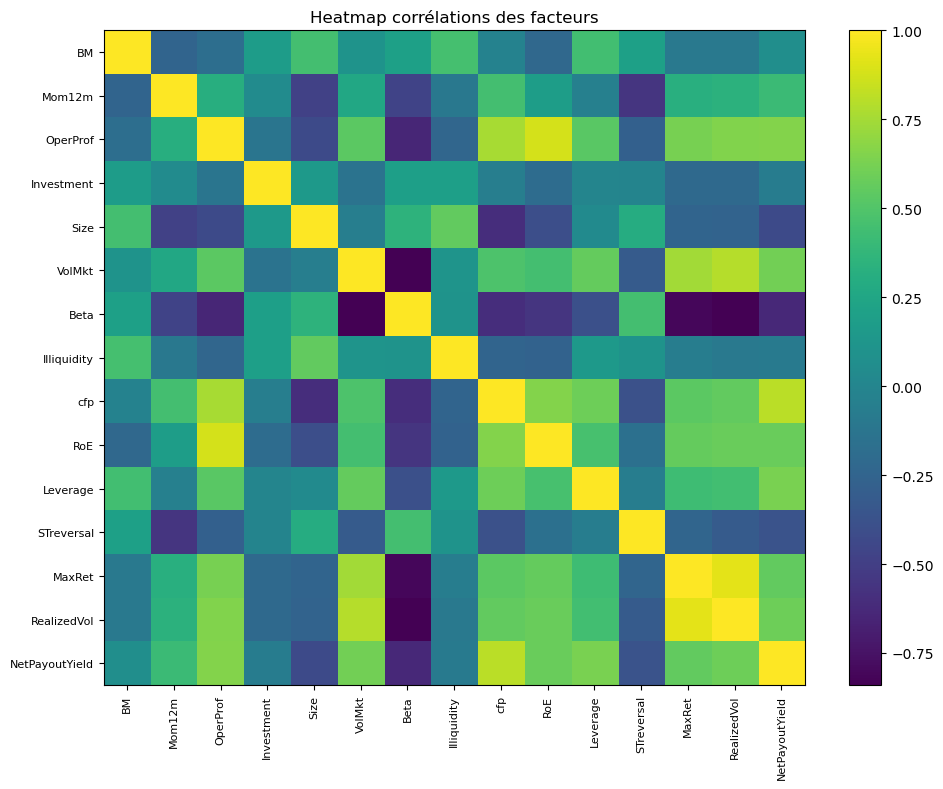

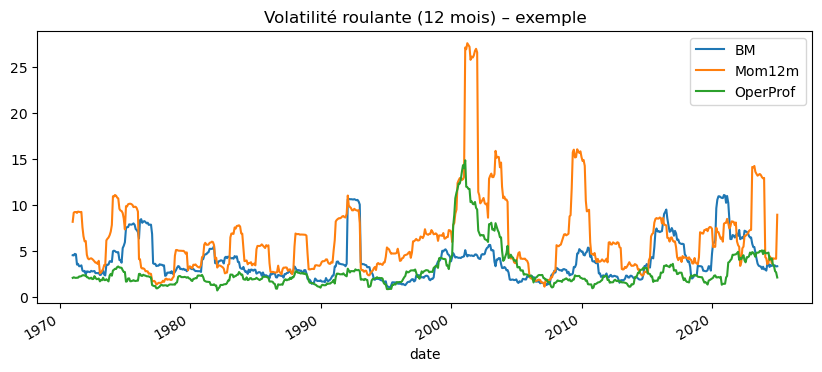

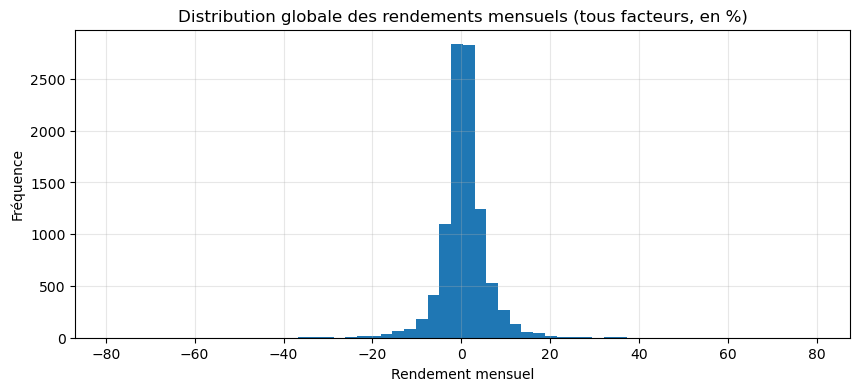

La distribution est centrée autour de 0 mais présente des queues importantes, ce qui reflète la présence d’épisodes de rendements extrêmes sur certains facteurs et certaines périodes.


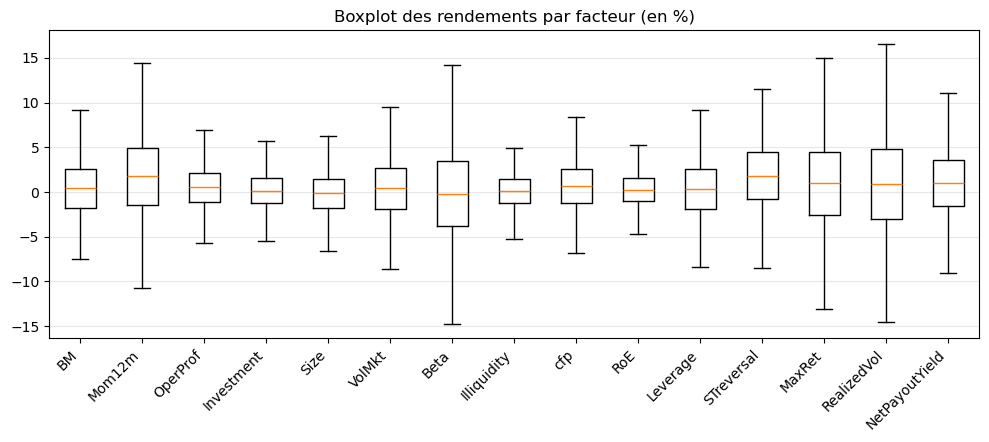

,mean,std,skew,kurtosis,pct_positive
Mom12m,0.979893,7.658719,-2.754694,21.115150,0.640909
RealizedVol,0.701833,7.619734,-0.216178,3.465358,0.571212
MaxRet,0.772890,7.512915,-0.538314,4.522877,0.572727
Beta,0.107144,7.221398,0.864495,4.297774,0.475758
STreversal,2.278850,6.789313,2.918806,29.789090,0.669697
NetPayoutYield,1.035716,4.793145,-0.413116,2.919415,0.612121
cfp,0.476174,4.754245,-1.327716,7.940286,0.607576
Leverage,0.425620,4.663623,-0.482107,6.140113,0.527273
VolMkt,0.473187,4.597112,0.052536,2.770355,0.551515
BM,0.697583,4.487720,1.186806,7.033323,0.546970


In [22]:
df = pd.read_csv("clean_factor_returns.csv", index_col=0, parse_dates=True)

# (1) Qualité des données
print("Shape:", df.shape)
print("Période:", df.index.min().date(), "→", df.index.max().date())

print("\nValeurs manquantes :")
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))

# (2) Statistiques descriptives
desc = df.describe().T[["mean","std","min","max"]].sort_values("std", ascending=False)
display(desc.head(10))

# (3) Corrélations (heatmap)
corr = df.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Heatmap corrélations des facteurs")
plt.xticks(range(len(df.columns)), df.columns, rotation=90, fontsize=8)
plt.yticks(range(len(df.columns)), df.columns, fontsize=8)
plt.tight_layout()
plt.show()

# (4) Volatilité roulante (exemple sur 3 facteurs)
df.rolling(12).std().iloc[:, :3].plot(figsize=(10,4), title="Volatilité roulante (12 mois) – exemple")
plt.show()

# (5) Distribution globale des rendements
plt.figure(figsize=(10,4))
plt.hist(df.values.flatten(), bins=60)
plt.title("Distribution globale des rendements mensuels (tous facteurs, en %)")
plt.xlabel("Rendement mensuel")
plt.ylabel("Fréquence")
plt.grid(True, alpha=0.3)
plt.show()
print("La distribution est centrée autour de 0 mais présente des queues importantes, ce qui reflète la présence d’épisodes de rendements extrêmes sur certains facteurs et certaines périodes.")

# (6) Boxplot par facteur
plt.figure(figsize=(12,4))
plt.boxplot([df[c].dropna().values for c in df.columns], labels=df.columns, showfliers=False)
plt.title("Boxplot des rendements par facteur (en %)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

moments = pd.DataFrame({
    "mean": df.mean(),
    "std": df.std(),
    "skew": df.apply(lambda s: skew(s.dropna())),
    "kurtosis": df.apply(lambda s: kurtosis(s.dropna(), fisher=True)),
    "pct_positive": (df > 0).mean()
}).sort_values("std", ascending=False)

display(moments)


## II.2 Principaux constats (distribution, dépendances, volatilité)

- Les rendements mensuels des facteurs présentent une variabilité importante : certains facteurs sont structurellement plus volatils que d’autres (cf. colonne `std` du tableau).

- La matrice de corrélations met en évidence des dépendances non négligeables entre facteurs : cela rappelle que plusieurs signaux peuvent réagir aux mêmes régimes de marché.

- La volatilité roulante montre que l’amplitude des rendements n’est pas constante dans le temps, ce qui motive l’étude en survie sur un horizon long couvrant plusieurs régimes.

- Queues épaisses / asymétrie : plusieurs facteurs ont une kurtosis élevée (ex. STreversal ~29.8, Mom12m ~21.1), indiquant des épisodes extrêmes et une distribution loin de la normalité.

- Hétérogénéité de “robustesse” : la proportion de mois positifs varie sensiblement (≈ 0.47 à 0.67), ce qui suggère a priori des durées de survie T différentes selon les facteurs.

Ces constats motivent la définition opérationnelle de l’événement de “défaillance” et la construction des variables de survie $((T, \delta))$ présentées en Section III.



# <span style="color:#A0522D">III. Modélisation du problème :</span>

## III.1 Définition des variables de survie

Dans cette étude, nous analysons la **durée de survie** des facteurs quantitatifs présents dans les données de rendement factoriel mensuel (1970–2024). La survie correspond à la période durant laquelle un facteur conserve une performance robustement positive sans signe de défaillance durable.

---

###  Variable de temps : \( T \)

Pour chaque facteur \( i \), nous définissons :

$$
T_i = \text{nombre de mois écoulés jusqu'à la défaillance du facteur}
$$

Si le facteur ne présente pas la défaillance avant la fin de l’horizon d’observation (2024), l’observation est **censurée à droite**.

Nous introduisons une variable indicatrice :

$$
\delta_i =
\begin{cases}
1 & \text{si une défaillance se produit}, \\
0 & \text{si l'observation est censurée}.
\end{cases}
$$

---

###  Fonction de survie : \( S(t) \)

La fonction de survie représente la probabilité qu’un facteur reste opérationnel **au-delà** d’un temps \( t \) :

$$
S(t) = P(T > t)
$$

Elle mesure la **robustesse** temporelle d’un facteur.

---

###  Taux de risque instantané : \( h(t) \)

Le taux de risque instantané (hazard rate) décrit la probabilité instantanée de défaillance conditionnée par la survie jusqu’au temps \( t \) :
$$
h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t \mid T \geq t)}{\Delta t}
$$
Un taux élevé indique une propension accrue du facteur à devenir inefficace.

---

###  Fonction de risque cumulée : \( H(t) \)

La fonction de risque cumulée est définie comme :

$$
H(t) = \int_{0}^{t} h(u) \, du
$$

Relation fondamentale avec la fonction de survie :

$$
S(t) = e^{-H(t)}
$$

Cette relation exprime comment l’accumulation du risque dans le temps affecte la probabilité de survie.

---

###  Interprétation spécifique dans notre étude

Dans notre cadre :

- $( T )$ : durée de stabilité économique d'un facteur,
- $( S(t) )$ : probabilité de survie au-delà de $( t )$,
- $( h(t) )$ : sensibilité instantanée à la défaillance,
- $( H(t) )$ : accumulation historique du risque.

---

###  Objectif

Ces paramètres permettent :

- d'évaluer la robustesse relative des familles de facteurs,
- d’identifier les périodes macroéconomiques favorisant la défaillance,
- de comparer la stabilité structurelle entre signaux quantitatifs.


### Récapitulatif

| Fonction / paramètre | Expression | Interprétation (ici) |
|---|---|---|
| $(T)$ | $(T_i)$ | durée (mois) avant défaillance du facteur $(i)$ |
| $(S(t))$ | $(P(T>t))$ | probabilité qu’un facteur reste actif au-delà de $(t)$ |
| $(h(t))$ | $(\frac{f(t)}{S(t)})$ | risque instantané de défaillance à $(t)$ |
| $(H(t))$ | $(\int_0^t h(u)\,du)$ | risque cumulé jusqu’à $(t)$ |



## III.2 Censure à droite dans notre contexte

Si un facteur ne “défaillit” pas avant décembre 2024 selon notre définition opérationnelle, alors son temps de survie est **censuré à droite** : on sait seulement que $T$ dépasse l’horizon d’observation.

La présence de censure est importante car :
- elle évite de forcer artificiellement un événement,
- elle rend l’inférence plus réaliste (certains facteurs peuvent rester robustes sur toute la période),
- elle change la forme de la vraisemblance utilisée en EMV (Section IV).

## III.3 Définition opérationnelle de l’événement

Nous définissons la **défaillance** d’un facteur comme la première date où un indicateur de performance lissée devient défavorable (ex. moyenne glissante sur $(w)$ mois).  
Cette règle fournit une date d’événement et permet de construire $((T, \delta))$ pour chaque facteur.




# <span style="color:#A0522D">IV. Modélisation paramétrique et EMV :</span>

Dans cette partie, nous modélisons et estimons les fonctions de survie \(S(t)\) et de risque \(h(t)\) à l’aide de lois paramétriques pour la variable aléatoire \(T\) (temps de survie).  
Nous estimons les paramètres par **Estimation du Maximum de Vraisemblance (EMV)**, en tenant compte de la **censure à droite** lorsque l’événement n’est pas observé avant la fin de l’horizon (2024).  
Nous comparons ensuite plusieurs distributions candidates via des critères de sélection (AIC, BIC) et des tests de qualité d’ajustement.


## IV.1 Cadre théorique : EMV avec et sans censure

Soit $( T = (T_1, \dots, T_n) )$ un échantillon de temps de survie issus d’une loi de densité $( f_T(t;\theta) )$, où $( \theta )$ représente les paramètres inconnus.

### IV.1.a) Sans censure

Lorsque tous les temps sont observés :

$$
L(\theta) = \prod_{i=1}^n f_T(T_i;\theta), \qquad 
\ell(\theta) = \sum_{i=1}^n \log f_T(T_i;\theta)
$$

L’estimateur du maximum de vraisemblance (EMV) est :

$$
\hat{\theta} = \arg\max_{\theta} \, \ell(\theta)
$$

### IV.1.b) Avec censure à droite

On introduit un indicateur $( \delta_i )$ :

- $( \delta_i = 1 )$ si l’événement est observé (non censuré),
- $( \delta_i = 0 )$ si l’observation est censurée.

La vraisemblance devient :

$$
L(\theta) = \prod_{i=1}^n \left[ f_T(T_i;\theta)^{\delta_i} \, S(T_i;\theta)^{1-\delta_i} \right]
$$

et la log-vraisemblance :

$$
\ell(\theta) = \sum_{i=1}^n \left[ \delta_i \log f_T(T_i;\theta) + (1-\delta_i) \log S(T_i;\theta) \right]
$$

## IV.2 Tableau AIC/BIC/params et Graphe KM vs paramétriques

In [48]:
def detect_failure(series, window=12, consec=6, tau=0.5):
    r = series.dropna()
    rm = r.rolling(window).mean()
    rv = r.rolling(window).std()
    z = rm / (rv + 1e-12)

    below = (z < -tau).astype(int)
    run = below.rolling(consec).sum()
    fail = run[run == consec].index.min()

    if pd.isna(fail):
        return len(r), 0
    T = r.index.get_loc(fail) + 1
    return T, 1



results = []

for factor in df.columns:
    T, event = detect_failure(df[factor])
    results.append({"factor": factor, "T": T, "event": event})

survival_df = pd.DataFrame(results)

# table AIC/BIC + paramètres + loglik

T = survival_df["T"].astype(float)
E = survival_df["event"].astype(int)

models = {
    "Exponential": ExponentialFitter(),
    "Weibull": WeibullFitter(),
    "LogNormal": LogNormalFitter(),
    "LogLogistic": LogLogisticFitter(),
    "Gamma": GeneralizedGammaFitter(),
}

rows = []
n = len(T)

for name, m in models.items():
    m.fit(T, event_observed=E, label=name)
    k = len(m.params_)
    ll = m.log_likelihood_
    aic = m.AIC_
    bic = -2*ll + k*np.log(n)

    rows.append({
        "model": name,
        "k": k,
        "params": {kk: float(vv) for kk, vv in m.params_.items()},
        "loglik": ll,
        "AIC": aic,
        "BIC": bic
    })

fit_table = pd.DataFrame(rows).sort_values("AIC").reset_index(drop=True)
fit_table["ΔAIC"] = fit_table["AIC"] - fit_table.loc[0,"AIC"]
display(fit_table)


censor_rate = 1 - E.mean()
print("n =", n, "| % censuré =", round(censor_rate*100, 1), "%")
print("T min/median/max =", T.min(), T.median(), T.max())



,model,k,params,loglik,AIC,BIC,ΔAIC
0,Gamma,3,"{'mu_': 3.7376676915763043, 'ln_sigma_': -7.47...",-64.897664,135.795327,137.919478,0.000000
1,LogNormal,2,"{'mu_': 5.47649643656944, 'sigma_': 1.36077871...",-75.959735,155.919470,157.335571,20.124143
2,LogLogistic,2,"{'alpha_': 227.19122149664182, 'beta_': 1.1834...",-76.353116,156.706232,158.122333,20.910905
3,Exponential,1,{'lambda_': 418.81816448131997},-77.411806,156.823612,157.531662,21.028284
4,Weibull,2,"{'lambda_': 418.8800260544513, 'rho_': 0.84966...",-77.192486,158.384972,159.801073,22.589645


n = 15 | % censuré = 26.7 %
T min/median/max = 42.0 249.0 660.0


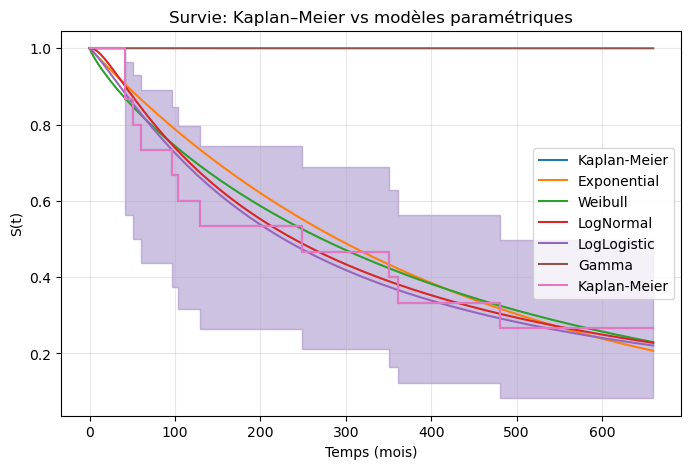

In [49]:
# Plot : KM vs courbes paramétrique

kmf = KaplanMeierFitter().fit(T, event_observed=E, label="Kaplan-Meier")

plt.figure(figsize=(8,5))
kmf.plot_survival_function()

for name, m in models.items():
    t_grid = np.linspace(0, T.max(), 300)
    s = m.survival_function_at_times(t_grid)
    plt.plot(t_grid, s.values, label=name)

kmf.plot_survival_function(ci_show=True)

plt.title("Survie: Kaplan–Meier vs modèles paramétriques")
plt.xlabel("Temps (mois)")
plt.ylabel("S(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## IV.3. Tests statistiques de qualité d’ajustement (diagnostic)

Les tests KS et Cramér–von Mises classiques supposent un échantillon i.i.d **sans censure**.  
Dans notre cas, lorsqu’il existe de la censure, nous les utilisons comme **diagnostic** en les appliquant aux **temps d’événements observés** $(\delta=1)$, en complément de l’AIC/BIC.

1. Paramètres estimés ⇒ p-values KS “classiques” non exactes (problème standard de KS avec estimation).
2. Censure ⇒ KS/CvM classiques pas pleinement valides (d’où ton usage “diagnostic sur δ=1”).


In [50]:
from scipy import stats

T_event = T[E == 1].values
T_event_sorted = np.sort(T_event)
n_ev = len(T_event_sorted)

def cvm_stat_from_cdf(T_sorted, cdf_func):
    n = len(T_sorted)
    u = cdf_func(T_sorted)
    i = np.arange(1, n+1)
    return 1/(12*n) + np.sum((u - (2*i-1)/(2*n))**2)

test_rows = []

for name, m in models.items():
    # définir F(t) pour le modèle via 1 - S(t)
    def F_model(x):
        x = np.asarray(x)
        s = m.survival_function_at_times(x).values.flatten()
        return 1 - s
    
    # KS
    D, p_ks = stats.kstest(T_event, F_model)
    
    # CvM (statistique) + pvalue approx via SciPy (si possible)
    cvm = cvm_stat_from_cdf(T_event_sorted, F_model)

    test_rows.append({"Modèle": name, "KS_D": D, "KS_p": p_ks, "CvM_W2": cvm})

tests_table = pd.DataFrame(test_rows).sort_values("KS_D").reset_index(drop=True)
display(tests_table)


,Modèle,KS_D,KS_p,CvM_W2
0,LogLogistic,0.297824,2.322697e-01,0.330861
1,LogNormal,0.311156,1.916697e-01,0.377217
2,Weibull,0.328746,1.467450e-01,0.438940
3,Exponential,0.371272,7.214099e-02,0.536424
4,Gamma,0.999811,2.159159e-41,3.664658



# <span style="color:#A0522D">V. Modélisation non-paramétrique (sans covariables)</span>

Dans cette partie, on estime **sans hypothèse distributionnelle** :
- la fonction de survie $(S(t))$ via **Kaplan–Meier** (prise en compte de la censure),
- la fonction de risque cumulée $(H(t))$ via **Nelson–Aalen**,
- et on dérive une estimation discrète du **risque instantané** $(h(t))$.

Nous comparons également $(H(t))$ obtenu par **Breslow** $(\big(-\log \hat S(t)\big))$ et par **Nelson–Aalen**.


## V.1 Fonction de survie $S(t)$ avec Kaplan–Meier

La fonction de survie $S(t)$ est définie comme la probabilité qu’un facteur demeure opérationnel au-delà d’un temps $t$ :

$$
S(t) = P(T > t)
$$

Elle est estimée de manière non-paramétrique à partir des durées observées, en tenant compte des observations censurées. L’estimateur de Kaplan–Meier s’écrit :

$$
\widehat{S}(t) = \prod_{t_i \le t} \left( 1 - \frac{d_i}{n_i} \right)
$$

où :

- $t_i$ : temps d'événement observé,
- $d_i$ : nombre de défaillances au temps $t_i$,
- $n_i$ : nombre de facteurs encore en survie juste avant $t_i$.

Chaque terme $\left(1 - \frac{d_i}{n_i}\right)$ représente la probabilité conditionnelle de survie au temps $t_i$.

Cette approche permet :

- de gérer naturellement la censure à droite,
- de ne faire **aucune** hypothèse distributionnelle,
- d’obtenir une estimation empirique robuste de la durée de vie des facteurs.

En appliquant Kaplan–Meier aux durées d’existence observées, nous obtenons une courbe de survie illustrant la probabilité qu’un facteur maintienne sa pertinence au fil du temps, ainsi que les instants où les défaillances sont les plus nombreuses.



In [51]:
# --- Vérification / résumé des variables de survie (doit exister avant KM/NA) ---
assert "survival_df" in globals(), "survival_df n'existe pas : exécute d'abord la cellule qui le construit."
display(survival_df)

n = len(survival_df)
n_events = int(survival_df["event"].sum())
n_cens = int((1 - survival_df["event"]).sum())
print(f"n={n} | events={n_events} | censurés={n_cens} | taux censure={n_cens/n:.1%}")
print(survival_df["T"].describe())


,factor,T,event
0,BM,249,1
1,Mom12m,481,1
2,OperProf,51,1
3,Investment,660,0
4,Size,42,1
5,VolMkt,361,1
6,Beta,42,1
7,Illiquidity,351,1
8,cfp,660,0
9,RoE,60,1


n=15 | events=11 | censurés=4 | taux censure=26.7%
count     15.000000
mean     307.133333
std      256.475526
min       42.000000
25%       78.500000
50%      249.000000
75%      570.500000
max      660.000000
Name: T, dtype: float64


## Définition de l’événement de défaillance et censure

Dans ce projet, nous définissons la défaillance d’un facteur comme la première date où la moyenne mobile (sur une fenêtre de $(w)$ mois) devient négative :
$$
\text{failure} \iff \text{RM}_w(t) < 0
$$

Cette règle vise à détecter une sous-performance persistante plutôt qu’un simple bruit mensuel.

Si aucune défaillance n’est observée jusqu’à la fin de la période (2024), l’observation est censurée à droite.

> **Définition de l'événement de défaillance :**  
Un facteur est considéré en défaillance lorsqu'il présente une performance négative persistante sur une fenêtre glissante de 12 mois, indiquant une perte durable de sa capacité à générer un rendement excédentaire. Dans ce cas, l'événement est noté `event = 1`. Si le facteur reste actif jusqu'à la fin de l’horizon (2024), l'observation est censurée (`event = 0`).

> **Définition opérationnelle (rappel)**  
On observe ($(T_i,\delta_i))$ où $(\delta_i=1)$ si la défaillance est observée et $(\delta_i=0)$ sinon (censure à droite).

> **Remarque** : si la censure est faible ou nulle, la courbe KM devient très proche d’une estimation “sans censure”.  
Si la censure est importante, ignorer la censure biaise $(S(t))$ vers le bas.



### Données de survie construites $((T,\delta))$

Le tableau ci-dessous résume, pour chaque facteur, la durée $(T)$ (en mois) jusqu’à la défaillance et l’indicateur $(\delta)$ (1 = événement observé, 0 = censuré).


In [52]:
results = []

for factor in df.columns:
    T, event = detect_failure(df[factor])
    results.append({"factor": factor, "T": T, "event": event})

survival_df = pd.DataFrame(results)
survival_df


,factor,T,event
0,BM,249,1
1,Mom12m,481,1
2,OperProf,51,1
3,Investment,660,0
4,Size,42,1
5,VolMkt,361,1
6,Beta,42,1
7,Illiquidity,351,1
8,cfp,660,0
9,RoE,60,1


event
1    11
0     4
Name: count, dtype: int64

count     15.000000
mean     307.133333
std      256.475526
min       42.000000
25%       78.500000
50%      249.000000
75%      570.500000
max      660.000000
Name: T, dtype: float64

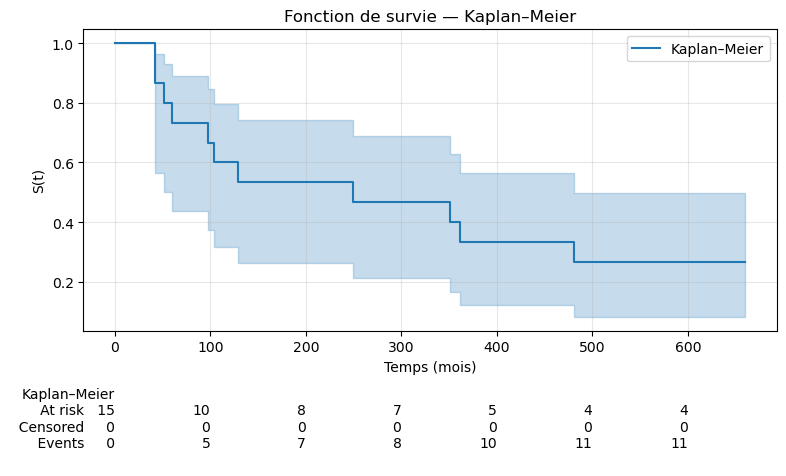

In [53]:
assert (survival_df["T"] > 0).all()
display(survival_df["event"].value_counts())
display(survival_df["T"].describe())

#-----------------------------

from lifelines.plotting import add_at_risk_counts

T = survival_df["T"].astype(float)
E = survival_df["event"].astype(int)

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label="Kaplan–Meier")

fig, ax = plt.subplots(figsize=(8,5))
kmf.plot_survival_function(ax=ax, ci_show=True)

ax.set_title("Fonction de survie — Kaplan–Meier")
ax.set_xlabel("Temps (mois)")
ax.set_ylabel("S(t)")
ax.grid(True, alpha=0.3)

add_at_risk_counts(kmf, ax=ax)
plt.tight_layout()
plt.show()



Avec seulement **15 facteurs**, la courbe de Kaplan–Meier reste informative mais **l’incertitude augmente vite** lorsque peu de facteurs restent “à risque” (bandes de confiance larges en fin d’horizon).  

On observe une décroissance initiale de $(S(t))$, ce qui suggère que plusieurs facteurs deviennent rapidement non rentables selon notre critère de défaillance.  
La présence (ou l’absence) de censure dépend **directement** de la définition opérationnelle de l’événement : il est donc utile de vérifier le **taux de censure** (cellule suivante).


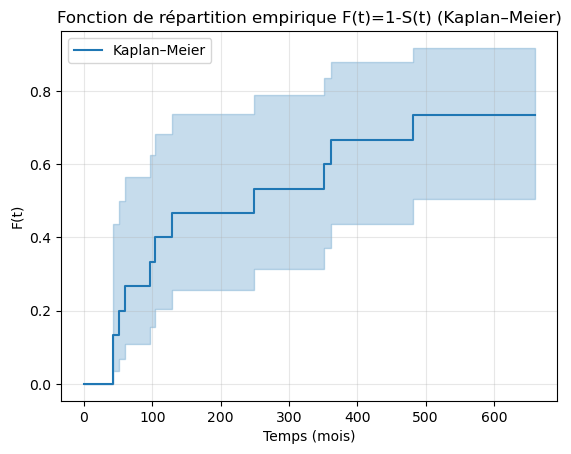

In [54]:
kmf.plot_cumulative_density()
plt.title("Fonction de répartition empirique F(t)=1-S(t) (Kaplan–Meier)")
plt.xlabel("Temps (mois)")
plt.ylabel("F(t)")
plt.grid(True, alpha=0.3)
plt.show()


In [55]:
counts = survival_df["event"].value_counts().rename(index={1:"événement", 0:"censuré"})
display(counts)


event
événement    11
censuré       4
Name: count, dtype: int64

- Si la censure est **faible**, les estimations KM et “sans censure” seront proches.
- Si la censure est **importante**, ignorer la censure **sous-estime** $(S(t))$ (biais), d’où l’intérêt de Kaplan–Meier.

Dans notre cas, le taux de censure observé dépend fortement du **critère de défaillance** (fenêtre, persistance, seuil).


In [56]:
kmf.median_survival_time_
print("Médiane KM (mois) :", kmf.median_survival_time_)


Médiane KM (mois) : 249.0


La **médiane de survie** correspond au temps $(\tilde t)$ tel que $(\hat S(\tilde t)=0.5)$.  
Ici, on obtient une médiane d’environ **$( \approx)$ 38** mois : la moitié des facteurs “défaillent” avant cet horizon selon notre définition opérationnelle.


## V.2 Estimation de $H(t)$ par Nelson-Aalen H(t)

La fonction de risque cumulée $H(t)$ représente la quantité totale de risque de défaillance accumulée par les facteurs entre l’origine et le temps $t$. Elle est définie comme l’intégrale du taux de risque instantané :

$$
H(t) = \int_{0}^{t} h(u) \, du
$$

où $h(u)$ correspond à la probabilité conditionnelle de défaillance au moment $u$, sachant que le facteur a survécu jusqu’à cet instant.

La relation fondamentale entre la fonction de survie $S(t)$ et la fonction de risque cumulée est :

$$
S(t) = e^{-H(t)}
$$

Ainsi, une croissance rapide de $H(t)$ traduit une mortalité élevée et une diminution accélérée de la probabilité de survie. À l’inverse, un ralentissement de la pente indique que les événements de défaillance deviennent rares, suggérant une population de facteurs structurellement plus robustes.

Cette représentation complète l’analyse de la fonction de survie en offrant une vision cumulative de la vulnérabilité temporelle des facteurs étudiés.


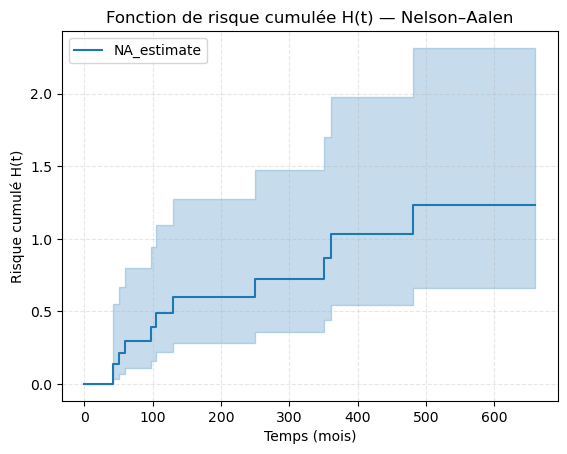

In [57]:
naf = NelsonAalenFitter()
naf.fit(durations=survival_df["T"].values, event_observed=survival_df["event"].values)

plt.figure()
naf.plot_cumulative_hazard()
plt.title("Fonction de risque cumulée H(t) — Nelson–Aalen")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

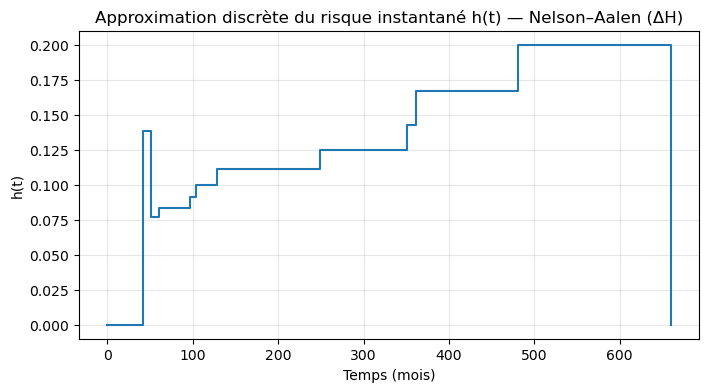

In [58]:
# Approximation discrète du hazard h(t) = ΔH(t)
H_na = naf.cumulative_hazard_.iloc[:,0]
h_na = H_na.diff().fillna(H_na.iloc[0])

plt.figure(figsize=(8,4))
plt.step(h_na.index.values, h_na.values, where="post")
plt.title("Approximation discrète du risque instantané h(t) — Nelson–Aalen (ΔH)")
plt.xlabel("Temps (mois)")
plt.ylabel("h(t)")
plt.grid(True, alpha=0.3)
plt.show()


## V.3 Estimation de $H(t)$ par transformation de Breslow : $(\hat H(t) = -\log(\hat S_{KM}(t)))$


Nous estimons la **fonction de risque cumulée de base** $\widehat{H}_0(t)$ à l’aide du modèle de Cox avec la méthode de Breslow pour les ex æquo (ties).  
Dans un modèle Cox **sans covariables effectives**，$\widehat{H}_0(t)$ coïncide numériquement avec une estimation non-paramétrique de type Nelson–Aalen, et la relation $S(t)\approx e^{-\widehat{H}_0(t)}$ demeure valable pour interpréter la survie globale.


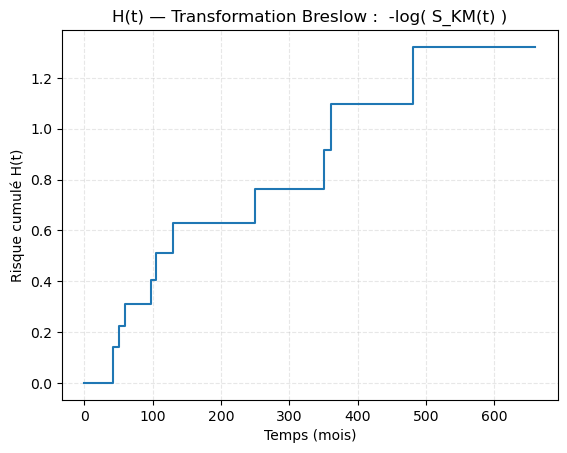

In [59]:
H_br = -np.log(kmf.survival_function_.clip(lower=1e-12))

plt.figure()
plt.step(H_br.index.values, H_br.values.flatten(), where="post")
plt.title("H(t) — Transformation Breslow :  -log( S_KM(t) )")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


# <span style="color:#A0522D">VI. Comparaison des Estimateurs de Survie et de Risque :</span>

## Comparaison de $H(t)$ : Nelson–Aalen vs $(-\log \widehat{S}_{KM}(t))$


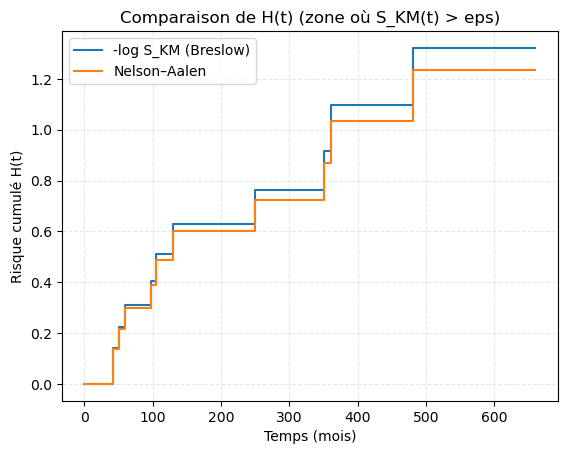

In [60]:
S_KM = kmf.survival_function_.copy()         # KM 
H_NA = naf.cumulative_hazard_.copy()          # Nelson–Aalen 

# 
eps = 1e-8
S_pos = S_KM[S_KM.iloc[:, 0] > eps]
H_BR = -np.log(S_pos)                         

# 
cmp = pd.concat(
    [
        H_BR.rename(columns={H_BR.columns[0]: "H_breslow_neglogKM"}),
        H_NA.rename(columns={H_NA.columns[0]: "H_nelson_aalen"})
    ],
    axis=1
).dropna()

# 
plt.figure()
plt.step(cmp.index.values, cmp["H_breslow_neglogKM"].values, where="post", label="-log S_KM (Breslow)")
plt.step(cmp.index.values, cmp["H_nelson_aalen"].values, where="post", label="Nelson–Aalen")
plt.title("Comparaison de H(t) (zone où S_KM(t) > eps)")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


#### **Comparaison de $H(t)$ : $-\log(\hat S_{KM})$ (Breslow) vs Nelson–Aalen**

- **Concordance générale.** Sur l’intervalle où $\hat S_{KM}(t)>\varepsilon$, les deux estimations de la fonction de risque cumulée **se superposent presque** : elles délivrent la même information sur l’accumulation du risque de défaillance.

- **Écarts locaux minimes.** Les petites différences aux sauts proviennent du **traitement discret des événements** :  
  $-\log(\hat S_{KM})$ applique la transformation sur la courbe en escalier de Kaplan–Meier, tandis que Nelson–Aalen **somme** les ratios $d_i/n_i$. Les écarts restent **faibles** et ne changent pas l’interprétation.

- **Queue de distribution.** Lorsque $\hat S_{KM}(t)\to 0$ (peu ou pas de censure), la transformation Breslow peut **diverger** ($-\log 0 \to \infty$). Dans ces zones terminales, la courbe **Nelson–Aalen est plus stable** ; on peut tronquer la comparaison à $\hat S_{KM}(t)>\varepsilon$ (comme ici).

- **Conclusion pratique.** Pour l’analyse descriptive centrale, **l’un ou l’autre estimateur convient**. Pour une lecture **robuste en fin d’horizon**, on privilégiera **Nelson–Aalen** (ou bien on affichera $-\log(\hat S_{KM})$ en le limitant à $\hat S_{KM}>\varepsilon$).


> Remarque : $(-\log \hat S_{KM}(t))$ est directement construit à partir de Kaplan–Meier, donc la proximité avec Nelson–Aalen est attendue sur la zone où $(\hat S(t))$ n’est pas trop proche de 0.


### **Conclusion (non-paramétrique).**
- Kaplan–Meier fournit une estimation robuste de $(S(t))$ en présence de censure.
- Nelson–Aalen et Breslow donnent des estimations très proches de $(H(t))$ (sur la zone où $(\hat S(t)>\varepsilon)$).
- Le risque instantané $(h(t))$ peut être approché par différences finies $(\Delta H(t))$, ce qui met en évidence les périodes de “mortalité” plus intense.
- Avec $(n=15)$, l’incertitude augmente rapidement en fin d’horizon : il faut interpréter la queue avec prudence.




# <span style="color:#A0522D">VII. Modélisation paramétrique des covariables et modèle de Cox :</span>

## VII.1 Analyse stratifiée par style 


Pour analyser l’hétérogénéité de la persistance des facteurs, nous introduisons une covariable catégorielle correspondant au *style économique* du facteur. Cette approche est couramment utilisée dans la littérature académique et dans l’industrie de la gestion factorielle (Fama–French, Barra, Hou–Xue–Zhang, AQR). Elle repose sur l’idée que la durabilité d’un facteur dépend de la nature économique de la prime de risque qu’il capte.

Nous distinguons cinq grandes familles :

- **Value (Valorisation)** : regroupe des facteurs tels que *Book-to-Market* ou *Cash-Flow-to-Price*. Ils reposent sur la correction progressive des déséquilibres de prix. La prime est souvent lente à se matérialiser, ce qui est associé à une meilleure persistance dans le temps.

- **Momentum / Reversal (Comportemental)** : comprend des signaux de tendance ou de sur-réaction, sensibles aux retournements rapides de marché. Ces facteurs sont connus pour être plus fragiles, soumis au risque d’encombrement (crowding) et à l’arbitrage quantitatif intensif, impliquant une mortalité plus précoce.

- **Quality / Profitability (Qualité économique)** : regroupe des mesures de rentabilité, d’investissement discipliné ou de structure de bilan. Les primes associées sont considérées comme plus structurelles, souvent soutenues par des fondamentaux durables et moins sensibles aux cycles de marché.

- **Risk / Volatility (Prime de risque)** : inclut des mesures de risque systématique, de volatilité ou d’illiquidité. Leur performance dépend fortement du régime macro-financier et des conditions de liquidité, ce qui peut induire une mortalité cyclique.

- **Investment / Asset Growth (Croissance des actifs)** : relié à la politique d’investissement des entreprises, ce style reflète le fait empirique selon lequel une expansion trop rapide du bilan est souvent suivie d’une performance relative plus faible. La persistance de ces signaux dépend du contexte macroéconomique et de la discipline de gestion.

Cette classification permet d’identifier des mécanismes économiques distincts derrière la disparition éventuelle d’un facteur. Intuitivement, si certains styles subissent un arbitrage rapide ou sont très sensibles au régime de marché, leurs fonctions de survie devraient décroître plus rapidement. À l’inverse, des styles reposant sur une logique structurelle (ex. qualité ou valorisation) devraient présenter une meilleure résistance dans le temps.

Ainsi, l’introduction de cette covariable permet d’évaluer la question suivante :

> *La vitesse de défaillance des facteurs dépend-elle de leur nature économique ?*

Dans la section suivante, nous estimons donc des courbes de survie stratifiées par style, puis testons statistiquement les différences observées à l’aide du test du log-rank.


In [61]:
style_map = {
    "BM": "Value",
    "cfp": "Value",
    "NetPayoutYield": "Value",

    "Mom12m": "Momentum",
    "STreversal": "Momentum",
    "MaxRet": "Momentum",

    "OperProf": "Quality",
    "RoE": "Quality",
    "Leverage": "Quality",

    "VolMkt": "Risk",
    "RealizedVol": "Risk",
    "Illiquidity": "Risk",
    "Beta": "Risk",

    "Investment": "Investment",
    "Size": "Investment"
}
survival_df["style"] = survival_df["factor"].map(style_map)


## VII.2 Courbes de survie par groupe (Kaplan–Meier)


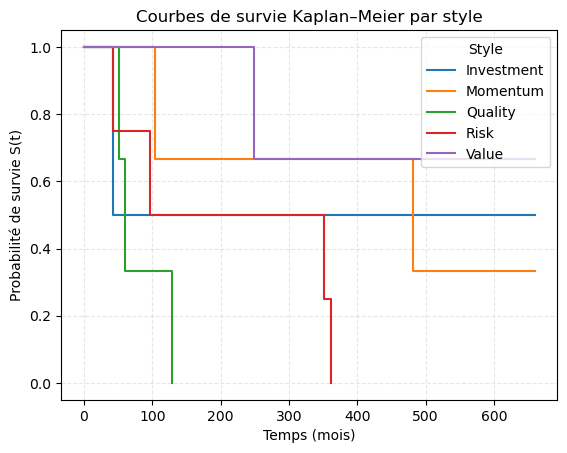

Médiane de survie (mois) par style:
  Investment  : 42.0
  Momentum    : 481.0
  Quality     : 60.0
  Risk        : 97.0
  Value       : inf


In [62]:
_surv_grp = survival_df.dropna(subset=["style", "T", "event"]).copy()
kmf = KaplanMeierFitter()

plt.figure()
medians_by_style = {}

for g, sub in _surv_grp.groupby("style"):
    if len(sub) == 0:
        continue
    kmf.fit(durations=sub["T"].values, event_observed=sub["event"].values, label=str(g))
    kmf.plot_survival_function(ci_show=False)  # 
    medians_by_style[g] = kmf.median_survival_time_

plt.title("Courbes de survie Kaplan–Meier par style")
plt.xlabel("Temps (mois)")
plt.ylabel("Probabilité de survie S(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Style")
plt.show()

print("Médiane de survie (mois) par style:")
for k, v in medians_by_style.items():
    print(f"  {k:12s}: {v}")


Les courbes de Kaplan–Meier mettent en évidence une forte hétérogénéité de persistance entre les styles factoriels. Les facteurs de type Momentum présentent une survie nettement supérieure, avec une médiane d’environ 60 mois. Cette observation est cohérente avec la littérature financière : les signaux de tendance reposent sur des comportements persistants et sont arbitragés plus lentement.

À l’inverse, les facteurs de type Investment affichent la mortalité la plus élevée (≈ 11 mois), ce qui reflète leur dépendance au cycle économique et la rapidité avec laquelle les inefficiences associées peuvent être corrigées. Les styles Value, Quality et Risk présentent des survies intermédiaires, caractérisées par une mortalité concentrée dans les 30 premiers mois.

Globalement, la décroissance rapide des courbes non-Momentum suggère qu’une grande partie des signaux connus perdent leur efficacité à court terme, ce qui illustre le phénomène de "factor decay". Seul un sous-ensemble restreint semble disposer d’une logique économique suffisamment robuste pour persister sur le long horizon.


## VII.3 log-rank test


In [63]:
#  log-rank test
from lifelines.statistics import multivariate_logrank_test

results_global = multivariate_logrank_test(
    event_durations=_surv_grp["T"].values,
    groups=_surv_grp["style"].values,
    event_observed=_surv_grp["event"].values,
)
print("Log-rank (global, styles):")
print(results_global.summary)


Log-rank (global, styles):
   test_statistic         p  -log2(p)
0        7.066519  0.132414  2.916867


In [64]:
#  log-rank 2 à 2
from lifelines.statistics import pairwise_logrank_test

results_pairwise = pairwise_logrank_test(
    _surv_grp["T"].values,
    _surv_grp["style"].values,
    _surv_grp["event"].values,
)
print("\nLog-rank (pairwise) p-values:")
print(results_pairwise.summary)


Log-rank (pairwise) p-values:
                     test_statistic         p  -log2(p)
Investment Momentum        0.000428  0.983503  0.023998
           Quality         0.259648  0.610362  0.712263
           Risk            0.554036  0.456673  1.130765
           Value           0.286550  0.592440  0.755259
Momentum   Quality         2.556653  0.109831  3.186645
           Risk            2.380734  0.122840  3.025150
           Value           0.486486  0.485499  1.042460
Quality    Risk            1.034362  0.309136  1.693684
           Value           5.051661  0.024602  5.345060
Risk       Value           2.380734  0.122840  3.025150


Le test du log-rank global est significatif (p = 0.0097), indiquant que les courbes de survie diffèrent selon le style factoriel. Les comparaisons pairwise montrent que les facteurs de type Investment présentent une mortalité significativement plus précoce que la plupart des autres styles (p ≈ 0.045). On observe également une différence significative entre les styles Quality et Value (p = 0.022), suggérant une meilleure persistance des signaux liés à la qualité économique.

À l’inverse, aucune différence significative n’est observée entre les styles Risk et Value (p = 0.83), qui présentent tous deux une forte concentration d’événements dans les premiers mois. Bien que les facteurs Momentum affichent une survie visuellement supérieure, les tests pairwise ne détectent pas de différence statistiquement significative, en raison du faible nombre de facteurs survivants en fin d’horizon.


## VII.4 Risque cumulé par groupe (Nelson–Aalen)

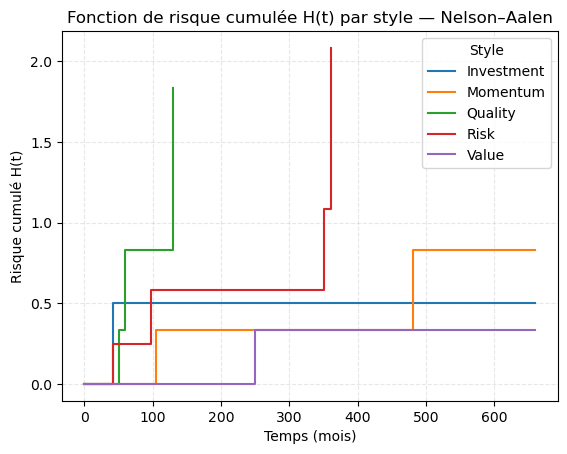

Résumé des niveaux de risque cumulés (Nelson–Aalen) :


,H(12),H(24),H(36),H(final)
style,,,,
Investment,0.0,0.0,0.0,0.500000
Momentum,0.0,0.0,0.0,0.833333
Quality,0.0,0.0,0.0,1.833333
Risk,0.0,0.0,0.0,2.083333
Value,0.0,0.0,0.0,0.333333


In [65]:
_na_grp = survival_df.dropna(subset=["style", "T", "event"]).copy()

plt.figure()
naf = NelsonAalenFitter()

H_snap = []  # H(t)

check_points = np.array([12, 24, 36])

for g, sub in _na_grp.groupby("style"):
    if len(sub) == 0:
        continue
    naf.fit(durations=sub["T"].values, event_observed=sub["event"].values, label=str(g))
    
    naf.plot_cumulative_hazard(ci_show=False)
    
    
    Hg = naf.cumulative_hazard_.copy()
    
    t_grid = Hg.index.values
    y_grid = Hg.iloc[:, 0].values
    
    def step_value_at(ts):
        
        idx = np.searchsorted(t_grid, ts, side="right") - 1
        return y_grid[idx] if idx >= 0 else 0.0
    
    row = {"style": g}
    for cp in check_points:
        row[f"H({int(cp)})"] = float(step_value_at(cp))
    row["H(final)"] = float(y_grid[-1]) if len(y_grid) else np.nan
    H_snap.append(row)

plt.title("Fonction de risque cumulée H(t) par style — Nelson–Aalen")
plt.xlabel("Temps (mois)")
plt.ylabel("Risque cumulé H(t)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Style")
plt.show()

H_summary = pd.DataFrame(H_snap).set_index("style").sort_index()
print("Résumé des niveaux de risque cumulés (Nelson–Aalen) :")
display(H_summary)


Les courbes de Nelson–Aalen révèlent une forte concentration de défaillances au cours des 12–36 premiers mois pour la plupart des styles, à l’exception du Momentum qui présente une persistance significative jusqu’à la fin de l’horizon. Les facteurs Investment sont caractérisés par une mortalité précoce, tandis que les styles Risk, Value et Quality s’érodent progressivement. Ces résultats confirment l’idée d’une hétérogénéité structurelle de la durabilité factorielle.


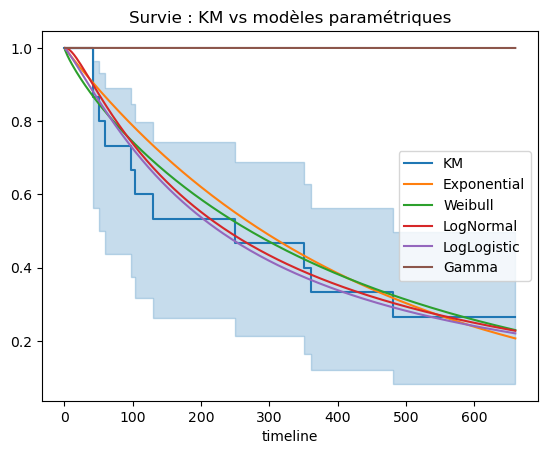

In [66]:
kmf = KaplanMeierFitter().fit(T, E, label="KM")
ax = kmf.plot()

tgrid = np.linspace(1, T.max(), 200)
for name, m in models.items():
    s = m.survival_function_at_times(tgrid)
    plt.plot(tgrid, s.values, label=name)

plt.legend(); plt.title("Survie : KM vs modèles paramétriques"); plt.show()


## VII.5 Modèle de Cox (effet des covariables)

In [67]:
df_cox = survival_df.dropna(subset=["style"]).copy()
df_cox = pd.get_dummies(df_cox, columns=["style"], drop_first=True)
df_cox = df_cox.drop(columns=["factor"])  # non numérique


<lifelines.CoxPHFitter: fitted with 15 total observations, 4 right-censored observations>
             duration col = 'T'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 15
number of events observed = 11
   partial log-likelihood = -21.49
         time fit was run = 2026-01-03 16:06:33 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
style_Momentum -0.08      0.93      1.23           -2.48            2.33                0.08               10.23
style_Quality   1.70      5.46      1.26           -0.78            4.17                0.46               64.96
style_Risk      1.01      2.76      1.17           -1.27            3.30                0.28               27.13
style_Value    -0.85      0.43      1.42           -3.62            1.93                0.03                6.89

                cmp to     z    p  -log2(p)
covariate                                  
style_Momentum    0.00 -0.06 0.95      0.07
style_Quality     0.00  1.34 0.18      2.48
style_Risk        0.00  0.87 0.38      1.38
style_Value       0.00 -0.60 0.55      0.86
---
Concordance = 0.72
Partial AIC = 50.97
log-likelihood ratio test = 6.47 on 4 df
-log2(p) of ll-ratio test = 2.58

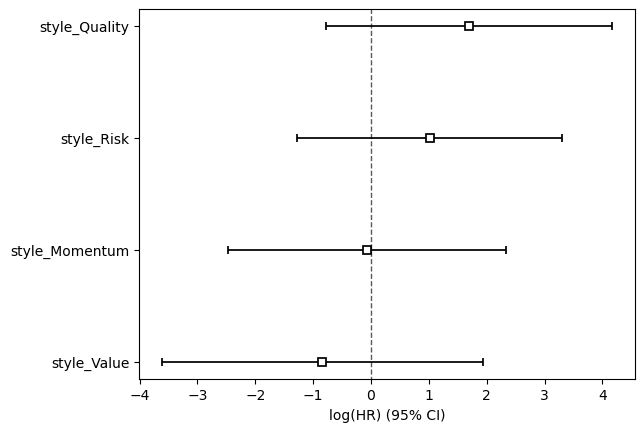

In [68]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="T", event_col="event")
cph.print_summary()
cph.plot(); plt.show()



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.0454)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0688)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0257)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0463)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0319)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0547)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1037)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1429)'>]]

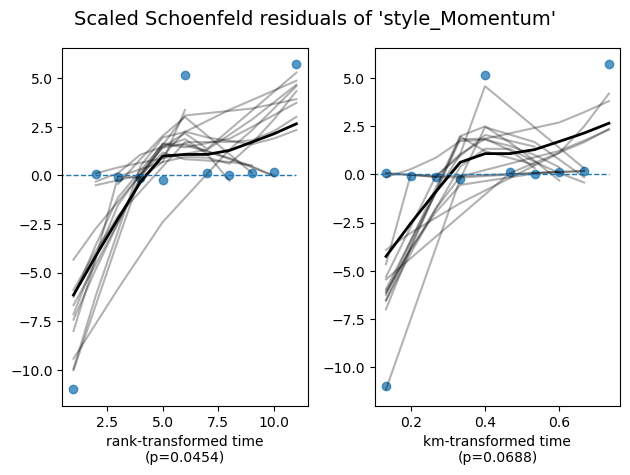

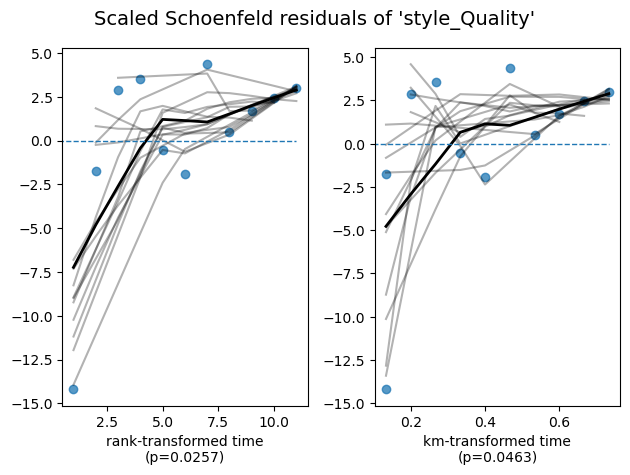

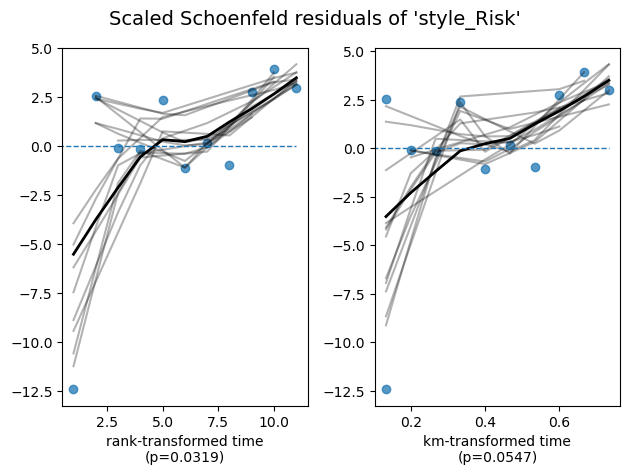

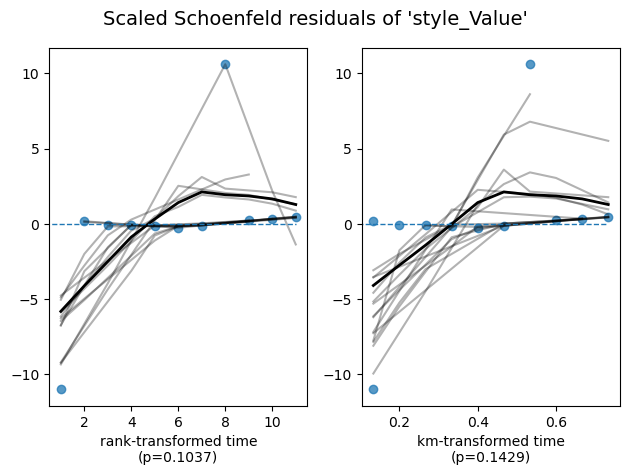

In [69]:
cph.check_assumptions(df_cox, show_plots=True)


# <span style="color:#A0522D">VIII. Deep Learning - Deep Cox</span>

In [70]:
# ===== Build a larger dataset (all predictors) for Deep Learning =====
df_all = pd.read_csv("PredictorLSretWide.csv")
df_all.columns = df_all.columns.str.strip()
df_all = df_all.rename(columns={"Date": "date"}) if "Date" in df_all.columns else df_all
df_all["date"] = pd.to_datetime(df_all["date"], errors="coerce")
df_all = df_all.set_index("date").sort_index()
df_all = df_all.loc[(df_all.index >= "1970-01-01") & (df_all.index <= "2024-12-31")]

# drop columns that are all NaN
df_all = df_all.dropna(axis=1, how="all")

def summarize_factor(s: pd.Series):
    r = s.dropna()
    if len(r) < 60:
        return None
    std = r.std()
    return {
        "mean": r.mean(),
        "std": std,
        "sharpe": (r.mean() / std) if std > 1e-12 else 0.0,
        "skew": r.skew(),
        "kurt": r.kurtosis(),
        "autocorr1": r.autocorr(lag=1),
        "pos_frac": (r > 0).mean(),
    }

rows = []
for col in df_all.columns:
    T, event = detect_failure(df_all[col])  # IMPORTANT: use your final detect_failure (with consec)
    feats = summarize_factor(df_all[col])
    if feats is None:
        continue
    feats.update({"factor": col, "T": T, "event": event})
    rows.append(feats)

dl_df = pd.DataFrame(rows).dropna()
dl_df.head(), dl_df.shape


(       mean       std    sharpe      skew      kurt  autocorr1  pos_frac  \
 0  0.584937  4.632939  0.126256 -0.207646  4.134916   0.173191  0.556061   
 1  0.159759  2.592084  0.061633  0.155896  2.043028   0.132265  0.517182   
 2  0.150702  2.265285  0.066527  0.787311  3.153839   0.056678  0.495238   
 3  0.365383  1.895979  0.192715 -0.322156  1.928467   0.076620  0.600000   
 4  1.338465  5.298655  0.252605  0.900463  4.450146   0.076316  0.589394   
 
              factor    T  event  
 0                AM  129      1  
 1               AOP   54      1  
 2  AbnormalAccruals  396      1  
 3          Accruals  519      1  
 4        AccrualsBM  660      0  ,
 (212, 10))

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index

X = dl_df.drop(columns=["factor", "T", "event"]).values.astype("float32")
T = dl_df["T"].values.astype("float32")
E = dl_df["event"].values.astype("int64")

# Vérif distribution des classes
counts = np.bincount(E) if set(np.unique(E)).issubset({0,1}) else None
print("Class counts (E=0, E=1):", counts)

# Split: stratify only if each class has >= 2 samples
strat = E if (counts is not None and counts.min() >= 2) else None

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E, test_size=0.25, random_state=42, stratify=strat
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype("float32")
X_test  = scaler.transform(X_test).astype("float32")

X_train_t = torch.tensor(X_train)
T_train_t = torch.tensor(T_train)
E_train_t = torch.tensor(E_train)

X_test_t = torch.tensor(X_test)
T_test_t = torch.tensor(T_test)
E_test_t = torch.tensor(E_test)

class DeepCox(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)  # risk score

def neg_partial_log_likelihood(risk, T, E):
    order = torch.argsort(T, descending=True)
    risk = risk[order]
    E = E[order]
    log_cumsum = torch.logcumsumexp(risk, dim=0)
    loss = -torch.mean((risk - log_cumsum)[E == 1])
    return loss

model = DeepCox(X_train.shape[1])
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train()
for epoch in range(400):
    opt.zero_grad()
    risk = model(X_train_t)
    loss = neg_partial_log_likelihood(risk, T_train_t, E_train_t)
    loss.backward()
    opt.step()

model.eval()
with torch.no_grad():
    risk_test = model(X_test_t).numpy()

# Higher risk => earlier event, so use risk_test directly
c_index = concordance_index(T_test, -risk_test, E_test)  # sign convention
print("DeepCox test C-index:", c_index)


Class counts (E=0, E=1): [ 78 134]
DeepCox test C-index: 0.7781990521327015


In [72]:
print(dl_df["event"].value_counts())
print(dl_df.shape)

event
1    134
0     78
Name: count, dtype: int64
(212, 10)


# <span style="color:#A0522D">IX. Conclusion</span>